In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt

import nest_asyncio
nest_asyncio.apply()
import pyshark
import numpy as np
from PIL import Image

In [2]:
%matplotlib inline

In [3]:
## Loading data

In [4]:
def loadDataset(path):
    cap = pyshark.FileCapture(path, use_json=True, include_raw=True)
    dataset = []

    for c in cap:
        arr = np.zeros((75, 20, 3), dtype=np.uint8)
    
        x, y = 0, 0
        for e in list(c.get_raw_packet()):
            arr[x, y] = [e, e, e]
            x += 1
            if x == 75:
                x = 0
                y += 1
            if y == 20:
                break
        dataset.append(arr)
    return dataset

In [5]:
def frameToImg(frame):
    return Image.fromarray(frame, 'RGB')

In [6]:
badQueries = loadDataset('./dataset/badHttpQueriesFiltered.pcap')

badCount = len(badQueries)

In [7]:
badCount

263750

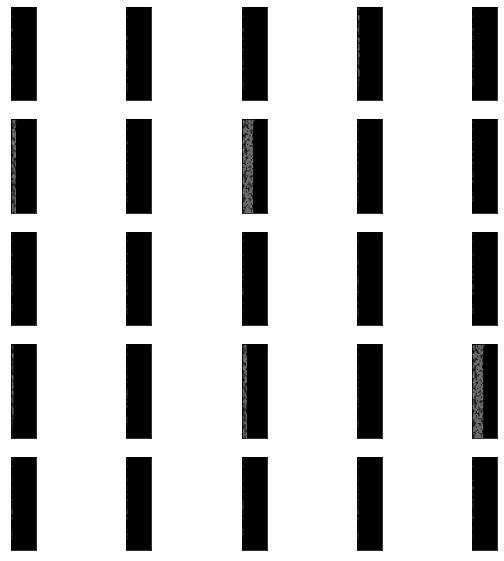

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(frameToImg(badQueries[i]))
plt.show()

In [9]:
validQueries = loadDataset('./dataset/goodHttpQueriesFiltered.pcap')

validCount = len(validQueries)

In [10]:
validCount

255402

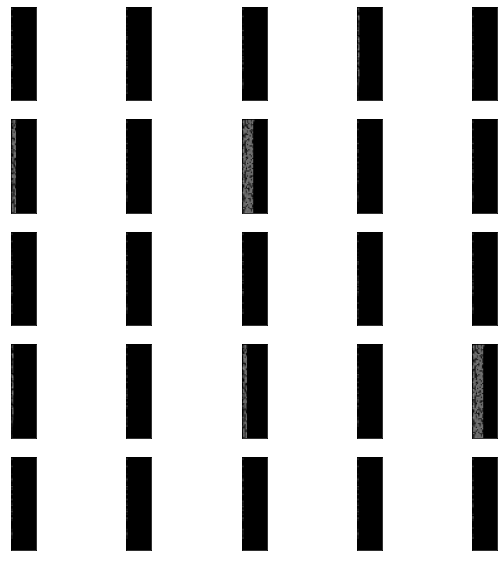

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(frameToImg(validQueries[i]))
plt.show()

In [12]:
## Preparing the dataset

In [13]:
yBad = [1 for i in range(0, len(badQueries))]  #labels, 1 for malicious and 0 for clean
yGood = [0 for i in range(0, len(validQueries))]

In [14]:
X = badQueries + validQueries
y = yBad + yGood

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #splitting data

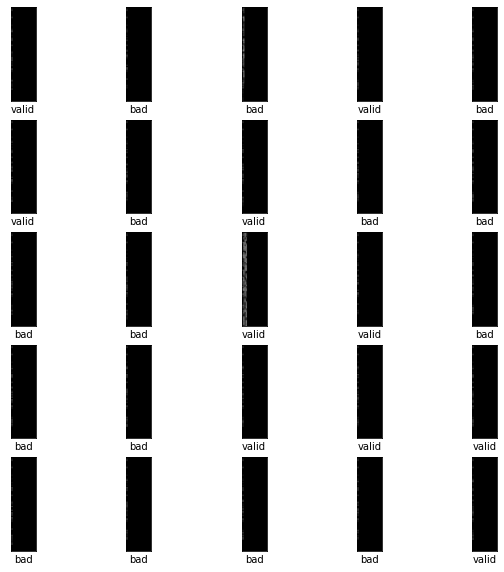

In [16]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(frameToImg(X_test[i]))
    plt.xlabel("bad" if y_test[i] else "valid")
plt.show()

In [17]:
## Building the model

In [18]:
def gen_model(hidden_layer_count, hidden_layer_size, activation_fn='sigmoid'):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation=activation_fn, input_shape=(75, 20, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activation_fn))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation=activation_fn))

    model.add(Flatten())

    for _ in range(hidden_layer_count):
        model.add(Dense(hidden_layer_size, activation=activation_fn))
    model.add(Dense(1))
    
    #model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=['accuracy'])
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    
    return model

In [19]:
model = gen_model(6, 128)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 18, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 9, 32)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 7, 64)         18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 3, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 1, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               1

In [21]:
## Training

In [22]:
def train_model(model, epochs, batch_size, X_train, y_train, X_test, y_test):
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))
    
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=3)

    return model, test_loss, test_acc, history

In [23]:
model, test_loss, test_acc, history = train_model(model, 5, 32, X_train, y_train, X_test, y_test)

Epoch 1/5
12979/12979 [==============================] - 296s 23ms/step - loss: 0.2532 - accuracy: 0.5012 - val_loss: 0.2507 - val_accuracy: 0.4928
Epoch 2/5
12979/12979 [==============================] - 307s 24ms/step - loss: 0.2523 - accuracy: 0.5005 - val_loss: 0.2505 - val_accuracy: 0.5072
Epoch 3/5
12979/12979 [==============================] - 273s 21ms/step - loss: 0.2518 - accuracy: 0.5012 - val_loss: 0.2506 - val_accuracy: 0.4928
Epoch 4/5
12979/12979 [==============================] - 257s 20ms/step - loss: 0.2511 - accuracy: 0.5019 - val_loss: 0.2500 - val_accuracy: 0.5072
Epoch 5/5
12979/12979 [==============================] - 260s 20ms/step - loss: 0.2504 - accuracy: 0.5022 - val_loss: 0.2500 - val_accuracy: 0.5072


In [24]:
## Metrics

In [25]:
print("Loss: ", test_loss)
print("Accuracy: ", test_acc)

Loss:  0.25002357363700867
Accuracy:  0.5071895718574524


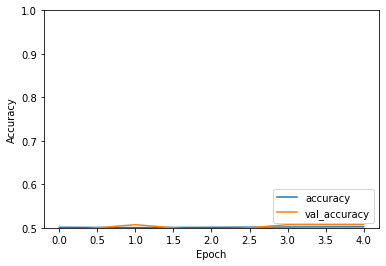

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [27]:
## Testing

In [28]:
def frame_is_bad(frame):
    return round(max(0., min(1., model.predict(np.array([frame]))[0][0])) * 100, 2)

In [29]:
frameToImg(X_test[0])

In [30]:
print("Is bad ?", frame_is_bad(X_test[0]), "%")

Is bad ? 51.58 %
